In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import s2_selection_utility as ssu

Start import
Working on midway2-0413.rcc.local with the following versions 
and installation paths:
strax
	v0.13.3	/dali/lgrandi/strax/strax/strax
straxen
	v0.14.3	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [4]:
dsets = st.select_runs(exclude_tags='messy', run_mode='tpc_commissioning_kr83m*',
                       available='event_basics')

In [5]:
dsets.head(20)

,name,number,mode,start,end,tags,livetime,peak_basics_available,raw_records_available,event_basics_available
83,011682,11682,tpc_commissioning_kr83m_test_trg_4ms,2021-01-05 16:42:54.842,2021-01-05 16:52:03.978,,00:09:09.136000,True,False,True
85,011680,11680,tpc_commissioning_kr83m_test_trg_4ms,2021-01-05 16:22:29.803,2021-01-05 16:24:49.202,,00:02:19.399000,True,False,True
86,011679,11679,tpc_commissioning_kr83m_test_trg_4ms,2021-01-05 15:22:14.045,2021-01-05 16:22:15.548,,01:00:01.503000,True,False,True
87,011678,11678,tpc_commissioning_kr83m_hev,2021-01-05 15:12:54.421,2021-01-05 15:13:33.182,,00:00:38.761000,True,False,True
89,011676,11676,tpc_commissioning_kr83m_hev,2021-01-05 14:57:35.150,2021-01-05 15:12:37.156,,00:15:02.006000,True,False,True
90,011675,11675,tpc_commissioning_kr83m_test_trg_6ms,2021-01-05 14:56:21.026,2021-01-05 14:56:50.556,,00:00:29.530000,True,False,True
91,011674,11674,tpc_commissioning_kr83m_test_trg_6ms,2021-01-05 14:41:02.440,2021-01-05 14:56:03.794,,00:15:01.354000,True,False,True
92,011673,11673,tpc_commissioning_kr83m_test_trg_6ms,2021-01-05 14:25:46.167,2021-01-05 14:40:48.153,,00:15:01.986000,True,False,True
93,011672,11672,tpc_commissioning_kr83m_test_trg_4ms,2021-01-05 14:21:04.783,2021-01-05 14:23:54.663,,00:02:49.880000,True,False,True
94,011671,11671,tpc_commissioning_kr83m_test_trg_4ms,2021-01-05 14:05:45.596,2021-01-05 14:20:47.565,,00:15:01.969000,True,False,True


In [3]:
run_id = '011673'
events = st.get_array(run_id,'event_info')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

In [4]:
def plot_area_width(events,run_id, low = 0, high = 6, low2 = 1, high2 = 4.5, binning = 500):
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    phcs1 = Histdd(events['cs1'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    phcs2 = Histdd(events['cs2'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("corrected peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')

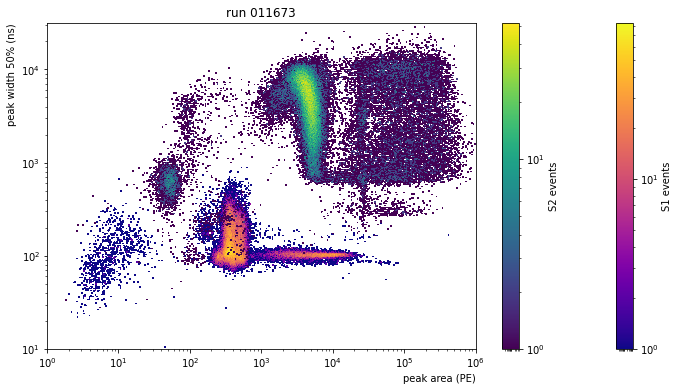

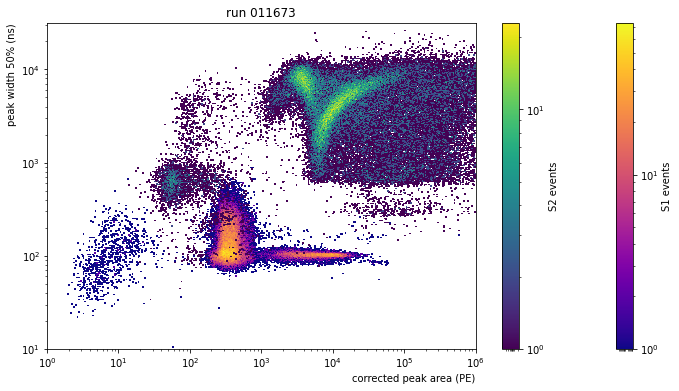

In [5]:
plot_area_width(events,'011673')

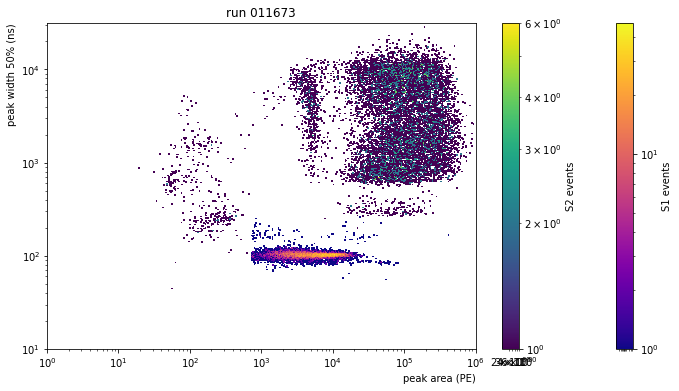

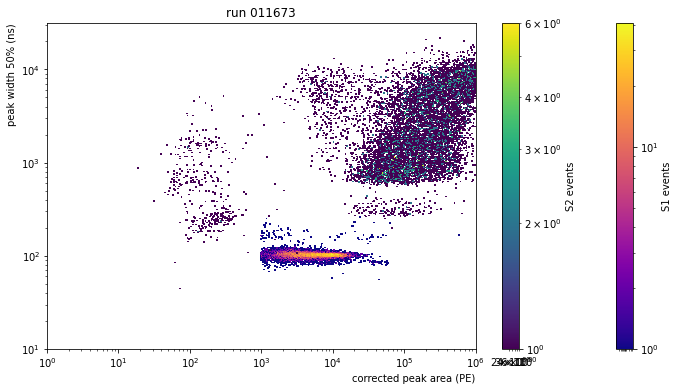

In [6]:
#events_cut = events[(events['cs1']>100)&(events['cs1']<1000)]
events_cut = events[(events['cs1']>1000)]
plot_area_width(events_cut,'011673')

# Drift Velocity

In [7]:
def drift_velocity(events,run_id, low = 0, high = 6000, binning = 500):
    plt.figure(figsize=(12,6))
    hdtime = Hist1d(events['drift_time']/1e3, bins=(np.linspace(low, high, binning)))
    hdtime.plot()
    plt.ylabel("events", ha='right', y=1)
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
    plt.yscale('log')
    plt.axvline(x=2500,linewidth=1,linestyle='--', color='r',label='cathode drop-off')
    plt.legend()
    
    plt.figure(figsize=(12,6))
    area_ratio = np.divide(events['cs2'],events['cs1'])
    mh = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(np.linspace(0, 6000, 200), np.logspace(0, 5, 200)))
    mh.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    
    plt.figure(figsize=(12,6))
    mh_low = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(np.linspace(0, 20, 200), np.logspace(0, 5, 200)),axis_names=['drift_time', 'area_ratio'])
    mh_low.plot(log_scale=True, cblabel='events')
    median = mh_low.percentile(50, axis='area_ratio')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2/S1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    median.plot(color='red',label='median')
    plt.yscale('log')
    plt.axvline(x=4,linewidth=1,linestyle='--', color='b',label='gate drift time')
    plt.legend(fontsize=14)
    vd = 150/(2500-4)*1e4
    print(f'Drift velocity = {vd:.2f} m/s')
    return vd

Drift velocity = 600.96 m/s


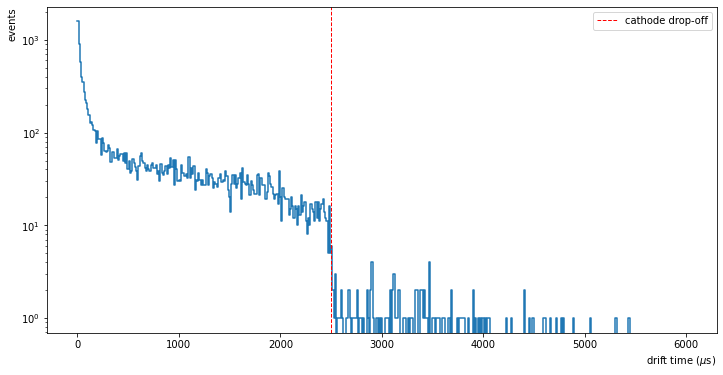

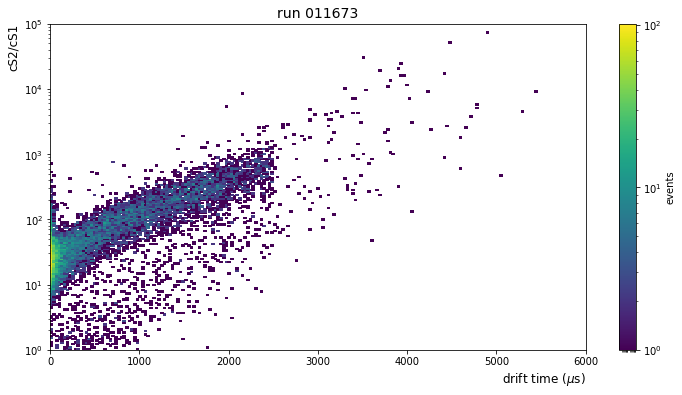

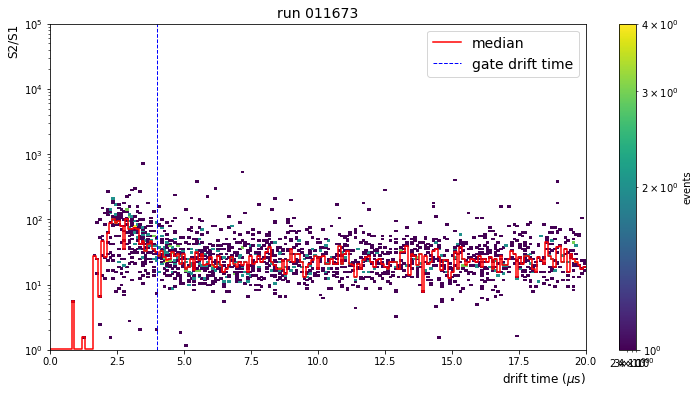

In [8]:
vd = drift_velocity(events_cut,'011673')

In [9]:
def plot_drift_time_aft(events,run_id, low = 0, high = 6000,
                        low2 = 0, high2 = 1, binning = 500):
    x = np.linspace(low, high, binning)
    pha1 = Histdd(events['drift_time']/1e3, events['s1_area_fraction_top'],
                bins=(x, np.linspace(low2, high2, binning)))
    pha2 = Histdd(events['drift_time']/1e3, events['s2_area_fraction_top'],
                bins=(x, np.linspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    pha1.plot(log_scale=True, cblabel='events')
    
    plt.plot(x, 0.54-2.1*x/1e4,color='r',linestyle='-')#,label='$0.54-2.1\cdot10^{-4} drifttime$')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S1 area fraction top", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    #plt.legend()
    #plt.figure(figsize=(12,6))
    #pha2.plot(log_scale=True, cblabel='events')
    #plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    #plt.ylabel("S2 area fraction top", ha='right', y=1,fontsize=12)
    #plt.title(f'run {run_id}',fontsize=14)

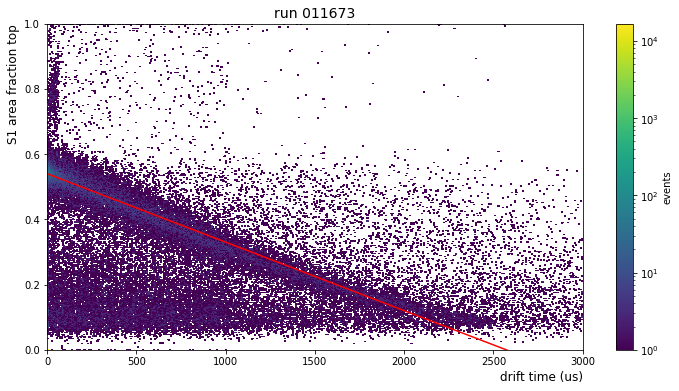

In [10]:
plot_drift_time_aft(events,'011673',0,3000)

# Diffusion Constant
The diffusion constant $D$ describes the diffusive broadening of electron clouds, and eventually the S2 signals, with increasing drift time.

\begin{equation}
\sigma = \frac{\sqrt{2 D t}}{v}
\end{equation}
for $t>30\mu$s per Sorensen), the diffusion makes the S2 gaussian-like, so the width can be calculated as:

\begin{equation}
\sigma = \sqrt{\frac{2 D t}{v^2} + {\sigma_0}^2}
\end{equation}
where $\sigma_0$ is a constant to set and correspond to the width of very shallow S2s.

Using the area_50% area $r_{50}$ we have:
\begin{equation}
 r_{50} \approx 1.349 \sigma = \sqrt{\frac{3.6395 D t}{v^2} + {w_0}^2}
\end{equation}

In [11]:
def diffusion_model(t, D, vd, w0):
    sigma_to_r50p = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)        
    return np.sqrt(2 * sigma_to_r50p**2 * D * t / vd**2 + w0**2)

In [12]:
def plot_widht_vs_drift_time(events,run_id, vd = 600, low = 0, high = 4000,
                    harea = 6, hwidth = 4.5, binning = 500):
    t = np.linspace(low, high, binning)
    phd = Histdd(events['drift_time']/1e3, events['s2_area'],
                bins=(t, np.logspace(1, harea, binning)))
    phw2 = Histdd(events['drift_time']/1e3, events['s2_range_50p_area'],
                bins=(t, np.logspace(2, hwidth, binning)))
    #plt.figure(figsize=(12,6))
    #phd.plot(log_scale=True, cblabel='events')
    #plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    #plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    #plt.title(f'run {run_id}',fontsize=14)
    #plt.yscale('log')
    plt.figure(figsize=(12,6))
    phw2.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    
    D_guess = 40000 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    vd = vd * units.m/units.s
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = diffusion_model(t, *guess)
    ys_u = diffusion_model(t, *guess) + 1000
    ys_d = diffusion_model(t, *guess) - 1000
    plt.plot(t, ys_d, c='r',linestyle='--')
    plt.plot(t, ys_u, c='r',linestyle='--')
    #plt.plot(t, ys_m, c='r')

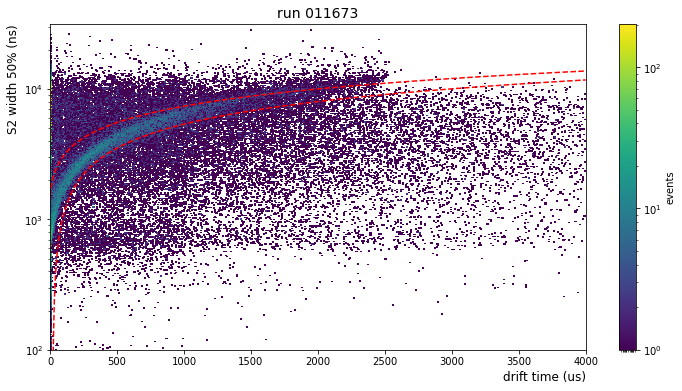

In [13]:
plot_widht_vs_drift_time(events,'011673',vd)

In [14]:
def diffusion_constant(run_id, area_bounds, aft_bounds, fit_range, vd = 600, plot = False):
    events = st.get_array(run_id,'event_info')
    
    # s2_area vs s2_area_fraction_top
    if plot:
        plt.figure(figsize=(12,6))
        ph = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(3, 6, 500), np.linspace(0.65, 0.85, 500)))
        ph.plot(log_scale=True, cblabel='events')
        plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
        plt.ylabel("S2 area fraction top", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        plt.xscale('log')
        plt.gca().add_patch(matplotlib.patches.Rectangle((area_bounds[0],aft_bounds[0]),
                                                     area_bounds[1]-area_bounds[0],
                                                     aft_bounds[1]-aft_bounds[0],
                                                     edgecolor='r',facecolor='none'))
        plt.figure(figsize=(12,6))
        
        #plt.figure(figsize=(12,6))
        #pph = Histdd(events['s2_area'], events['e_ces'],
        #            bins=(np.logspace(3, 6, 500), np.logspace(0, 5, 500)))
        #pph.plot(log_scale=True, cblabel='events')
        #plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
        #plt.ylabel("Energy estimate [keVee]", ha='right', y=1,fontsize=12)
        #plt.title(f'run {run_id}',fontsize=14)
        #plt.xscale('log')
        #plt.yscale('log')
        #psu.rectangle(area_bounds,(3e2,1e5),'r')
        
    
    # cut on area & aft
    data_cut = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1]) & 
                      (events['e_ces']>3e2)]
    
    data_fit = data_cut[(data_cut['drift_time']>fit_range[0])&(data_cut['drift_time']<fit_range[1])]
        
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2500, 200)
    ph = Histdd(data_cut['drift_time']/1e3, data_cut['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    #plt.yscale('log')
    plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    mean = np.array(ph.average(axis=1))
    plt.plot(t[:len(mean)], mean, color='b',linestyle='--', label='mean per drift time slice')
    
    D_guess = 50e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    print(f'Drift velocity = {vd:.2f} m/s ')
    vd = vd * units.m / units.s
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = diffusion_model(t, *guess)
    plt.plot(t, ys_m, c='yellow',linestyle='--',label='initial guess')
    ll = np.where(t<fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: diffusion_model(x, D, vd, w0)
    popt, pcov = curve_fit(diffusion, t[ll:hh], mean[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(t, diffusion(t, *popt), label='fit result',color='r')
    plt.legend()
    print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} +/- {perr[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'w0 = {popt[1]/(units.ns):.2f} +/- {perr[1]/(units.ns):.2f} ns ')
    

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 600.96 m/s 
Diffusion constant = 48.62 +/- 0.71 cm^2/s 
w0 = 276.41 +/- 375.63 ns 


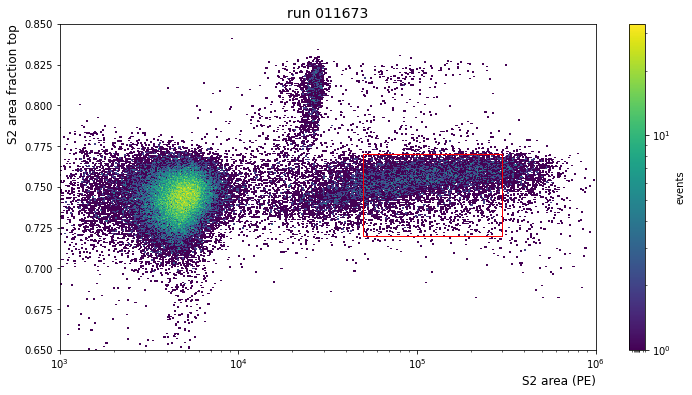

<Figure size 864x432 with 0 Axes>

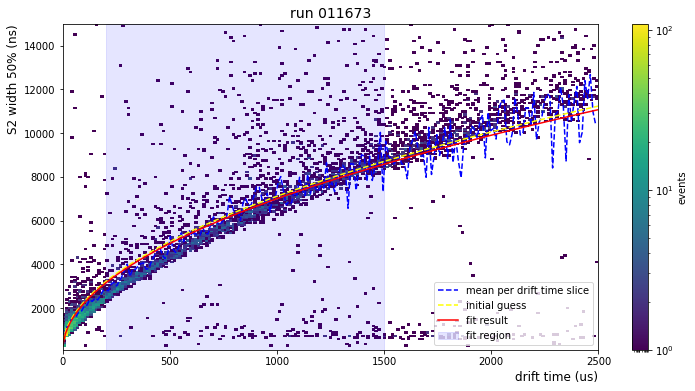

In [15]:
diffusion_constant('011673',area_bounds=(5e4,3e5),aft_bounds=(0.72,0.77),fit_range=(200,1500),vd=vd,plot=1)

# Event Display

In [16]:
def display_event(ev, nev = 0):
    st.event_display(run_id='011673', time_range=(ev[nev]['time'], ev[nev]['endtime']))

(raw)records not stored! Not showing records_matrix


|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

/dali/lgrandi/strax/straxen/straxen/matplotlib_utils.py:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = plt.scatter(


|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

/dali/lgrandi/strax/straxen/straxen/matplotlib_utils.py:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = plt.scatter(


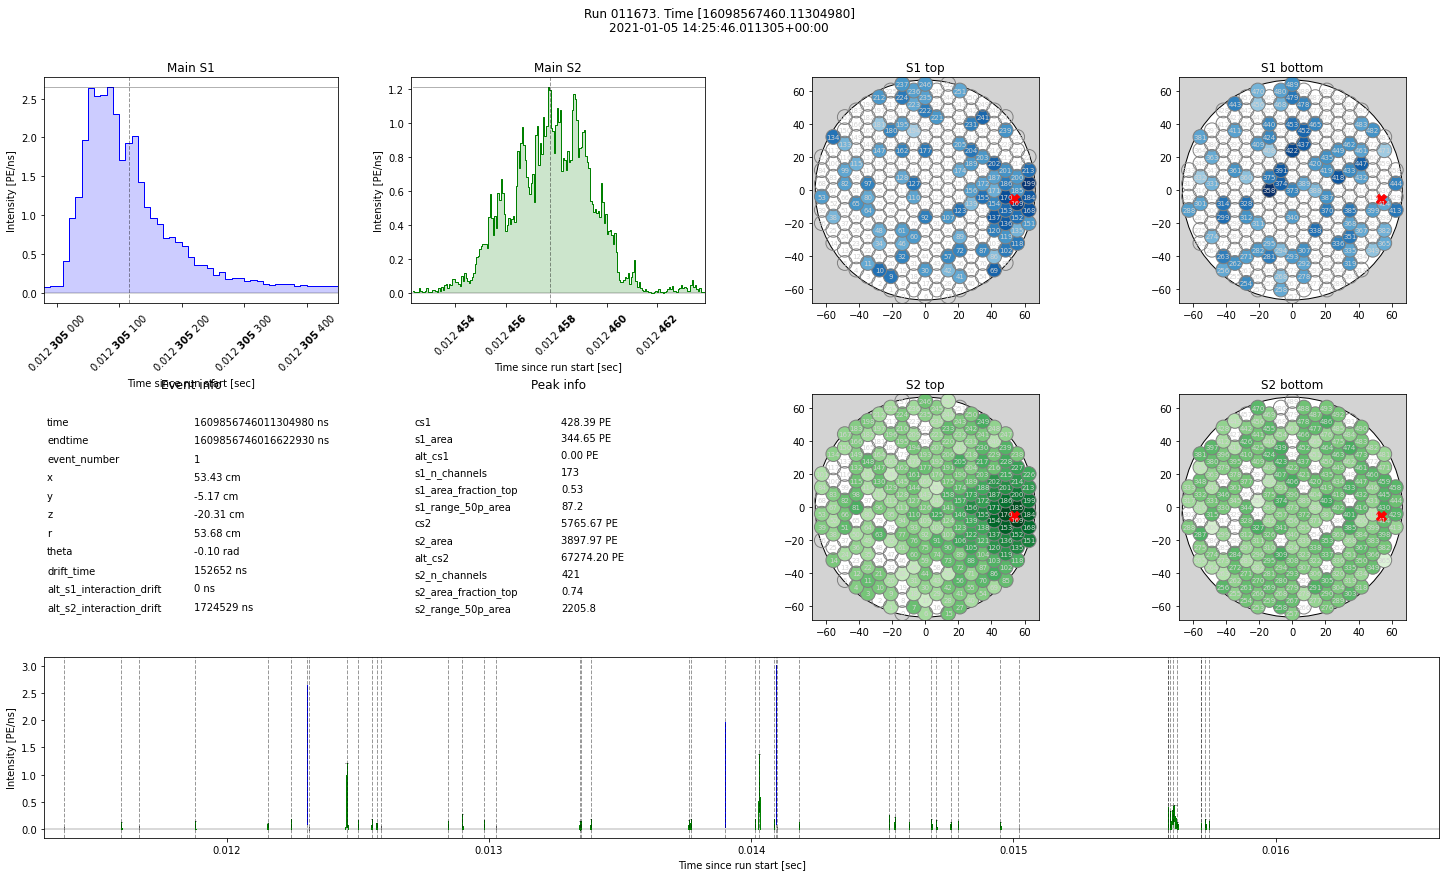

In [17]:
display_event(events,1)